## Loading black-box functions with TCI

Tensor cross-interpolation (TCI) is a method to load black-box functions in tensor trains or MPS. This library implements several variants of TCI, each with its advantages and drawbacks. In this example, we show the usage of the DMRG-based variant `cross_DMRG`, however, these examples apply analogously to all other variants by just replacing the method.

The black-box function given as input corresponds to a `BlackBox` object. There are several subclasses corresponding to different input black-boxes, applicable in different scenarios. In this notebook, we show a brief example for each type.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from seemps.analysis.mesh import (
    Mesh,
    RegularInterval,
    mps_to_mesh_matrix,
    interleaving_permutation,
)
from seemps.analysis.factories import mps_interval
from seemps.analysis.cross import (
    cross_interpolation,
    CrossStrategyDMRG,
    CrossStrategyMaxvol,
)
import seemps.tools

seemps.tools.DEBUG = 2

### 1. `BlackBoxLoadMPS`

This black-box representation allows to load functions in a MPS/TT with any structure. The quantization of the degrees of freedom in MPS cores, as well as their order in the MPS, is set by a linear transformation known as the `map_matrix`. This is a matrix that maps between the MPS indices and the integer coordinates of the `Mesh` indexing the function values on its multivariate domain. Some possibilities involve, for example, quantizing the degrees of freedom in different tensor orders, such as *serial (A)* and *interleaved (B)*. 

In this example, we load the function

$$
f(x, y) = e^{-(x^2 + y^2)}
$$

on a binary MPS with standard physical dimension 2 and serial order.

By convention, the input function `func` must be tensor-valued, where the first index of the tensors index the dimensions of the domain. For example, an input tensor of two dimensions $(x, y)$ where $x$ is discretized with size $N_x=2^{10}$ and $y$ with $N_y = 2^{12}$ would be of shape $(2, 2^{10}, 2^{12})$. TCI then evaluates the function on structured input tensors along the so-called fibers of the discretized domain.

 Iteration (half-sweep):   1/200, error: 1.104756329468188e-01/1.00e-08, maxbond:   2/1000, time: 0.005449/None, evals:     1120/None.
 Iteration (half-sweep):   2/200, error: 1.188717113398408e-05/1.00e-08, maxbond:   4/1000, time: 0.008827/None, evals:     1408/None.
 Iteration (half-sweep):   3/200, error: 1.443289932012704e-15/1.00e-08, maxbond:   8/1000, time: 0.011717/None, evals:     2064/None.
 State converged within tolerance 1e-08
Physical dimensions: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Max. error: 1.6653345369377348e-15


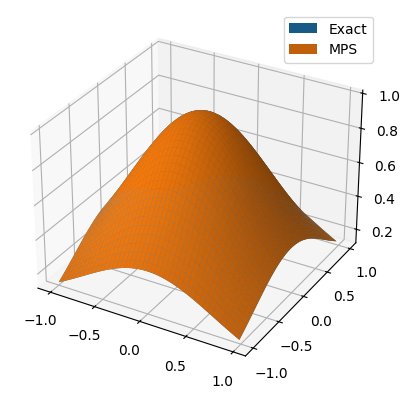

In [2]:
from seemps.analysis.cross import BlackBoxLoadMPS

func = lambda tensor: np.exp(-np.sum(tensor**2, axis=0))  # noqa: E731

start, stop = -1, 1
num_qubits = 7
num_points = 2**num_qubits
interval = RegularInterval(start, stop, 2**num_qubits)
dimension = 2
mesh = Mesh([interval] * dimension)

map_matrix = mps_to_mesh_matrix([num_qubits] * dimension)
physical_dimensions = [2] * num_qubits * dimension
black_box = BlackBoxLoadMPS(func, mesh, map_matrix, physical_dimensions)
cross_strategy = CrossStrategyDMRG()
mps = cross_interpolation(black_box, cross_strategy).mps
print(f"Physical dimensions: {mps.physical_dimensions()}")

x = interval.to_vector()
X, Y = np.meshgrid(x, x)
Z = np.stack([X, Y], axis=0)
Z_mps = mps.to_vector().reshape([num_points, num_points])
Z_vec = func(Z)

max_error = np.max(np.abs(Z_mps - Z_vec))
print(f"Max. error: {max_error}")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z_vec, label="Exact")
ax.plot_surface(X, Y, Z_mps, label="MPS")
ax.legend()

We can encode quantized MPS/QTT with the cores arranged in an arbitrary order by passing a permutation vector to the mapping matrix. This reorders the rows of the linear transformation representing the arrangement. Such arrangements are beneficial in some scenarios where the function has strong inter-dimensional correlations, leading to up-to exponential complexity advantages.

In this example, we encode the same Gaussian function in the interleaved qubit order. Interestingly, this function is exponentially complex in the interleaved order, as it has no interdimensional correlations. Often, what is simple in one order is very complex in the other and vice versa.

In [3]:
def reorder_tensor(tensor, sites_per_dimension):
    """
    Reorders a given tensor between the MPS orderings 'A' and 'B' by transposing its axes.
    """
    dimensions = len(sites_per_dimension)
    shape_orig = tensor.shape
    tensor = tensor.reshape([2] * sum(sites_per_dimension))
    axes = [
        np.arange(idx, dimensions * n, dimensions)
        for idx, n in enumerate(sites_per_dimension)
    ]
    axes = [item for items in axes for item in items]
    tensor = np.transpose(tensor, axes=axes)
    return tensor.reshape(shape_orig)


permutation = interleaving_permutation([num_qubits] * dimension)
sites_per_dimension = [num_qubits] * dimension
map_matrix = mps_to_mesh_matrix(sites_per_dimension, permutation)
black_box = BlackBoxLoadMPS(func, mesh, map_matrix, physical_dimensions)
cross_strategy = CrossStrategyMaxvol()
mps = cross_interpolation(black_box, cross_strategy).mps

Z_mps_interleaved = mps.to_vector().reshape(physical_dimensions)
Z_mps = reorder_tensor(Z_mps_interleaved, sites_per_dimension).reshape(
    [num_points, num_points]
)

max_error = np.max(np.abs(Z_mps - Z_vec))
print(f"Max. error: {max_error}")

 Iteration (half-sweep):   2/200, error: 7.210322463295209e-01/1.00e-08, maxbond:   3/1000, time: 0.006716/None, evals:     1228/None.
 Iteration (half-sweep):   4/200, error: 3.046025389254568e-01/1.00e-08, maxbond:   5/1000, time: 0.013167/None, evals:     1948/None.
 Iteration (half-sweep):   6/200, error: 5.074782197476713e-02/1.00e-08, maxbond:   7/1000, time: 0.019619/None, evals:     3396/None.
 Iteration (half-sweep):   8/200, error: 1.248607078487690e-02/1.00e-08, maxbond:   9/1000, time: 0.026317/None, evals:     5788/None.
 Iteration (half-sweep):  10/200, error: 3.775882327163804e-03/1.00e-08, maxbond:  11/1000, time: 0.034074/None, evals:     9220/None.
 Iteration (half-sweep):  12/200, error: 7.589612842466842e-04/1.00e-08, maxbond:  13/1000, time: 0.128332/None, evals:    13836/None.
 Iteration (half-sweep):  14/200, error: 9.299903751086580e-05/1.00e-08, maxbond:  15/1000, time: 0.205165/None, evals:    19828/None.
 Iteration (half-sweep):  16/200, error: 2.076910163406

We can employ the same tools to encode functions with no quantization (the so-called tensor-train (TT) representation). In this case, we do not assign a quantization with `map_matrix` and instead assume the default arguments. In this case, the function is a product state and trivially has a bond dimension 1, which TCI algorithms overestimate. 

In [4]:
start, stop = -1, 1
interval = RegularInterval(start, stop, num_points)
dimension = 2
mesh = Mesh([interval] * dimension)

black_box = BlackBoxLoadMPS(func, mesh)
cross_strategy = CrossStrategyMaxvol()
mps = cross_interpolation(black_box, cross_strategy).mps

Z_mps = mps.to_vector().reshape([num_points, num_points])
max_error = np.max(np.abs(Z_mps - Z_vec))
print(f"Max. error: {max_error}")

 Iteration (half-sweep):   2/200, error: 3.330669073875470e-16/1.00e-08, maxbond:   3/1000, time: 0.026495/None, evals:     2048/None.
 State converged within tolerance 1e-08
Max. error: 3.3306690738754696e-16


### 2. `BlackBoxLoadMPO`

This black-box representation supports loading bivariate functions as matrix-product operators (MPO). In the background, this simply encodes the equivalent MPS representation with combined indices and performs an index unfolding at the end of the algorithm. 

For this example, let us load the MPO for the bivariate function
$$
f(x, y) = e^{-(x^2 + y^2)},
$$
corresponding to a compressed representation of the operator $f_{ij} = e^{-(x_i^2 + y_j^2)}$.

The input function `func` must be bivariate, where the first and second dimensions respectively correspond to the operator rows and columns.

In [5]:
from seemps.analysis.cross import BlackBoxLoadMPO
from seemps.operators import mps_as_mpo

func = lambda x, y: np.exp(-(x**2 + y**2))  # noqa: E731

start, stop = -1, 1
num_qubits = 10
interval = RegularInterval(start, stop, 2**num_qubits)
dimension = 2
mesh = Mesh([interval] * dimension)

map_matrix = mps_to_mesh_matrix([num_qubits] * dimension, base=2)
black_box = BlackBoxLoadMPO(func, mesh)
cross_strategy = CrossStrategyDMRG()
mps = cross_interpolation(black_box, cross_strategy).mps
mpo = mps_as_mpo(mps)

x = interval.to_vector()
X, Y = np.meshgrid(x, x)
Z_vec = np.exp(-(X**2 + Y**2))
Z_mps = mpo.to_matrix()

max_error = np.max(np.abs(Z_mps - Z_vec))
print(f"Max. error: {max_error}")

 Iteration (half-sweep):   1/200, error: 1.077515940442658e-01/1.00e-08, maxbond:   4/1000, time: 0.023739/None, evals:     1552/None.
 Iteration (half-sweep):   2/200, error: 1.733308184798110e-05/1.00e-08, maxbond:  16/1000, time: 0.049197/None, evals:     8016/None.
 Iteration (half-sweep):   3/200, error: 5.638822742071170e-13/1.00e-08, maxbond:  59/1000, time: 0.187496/None, evals:    72208/None.
 State converged within tolerance 1e-08
Max. error: 1.0070833056374795e-12


### 3. `BlackBoxComposeMPS`

`BlackBoxComposeMPS` allows you to build a new MPS by **applying a multivariate scalar function to several input MPS**.
Each input MPS represents one “dimension” or variable of the function. The black box evaluates the function pointwise on the mesh encoded by each MPS and returns an MPS approximation of the resulting function.

Because the function acts on multiple MPS simultaneously, it must:

- receive an MPS list as input,
- return a **scalar MPS**, but computed **elementwise** from those inputs.

In this example, we construct three MPS representing the variables $x$, $y$, and $z$, all defined over the same interval. We then compose the function
$$
f(x, y, z) = x \sin(y z) + y \cos(x z),
$$
and ask TCI to compress it into an MPS.

In [6]:
from seemps.analysis.cross import BlackBoxComposeMPS

func = lambda mps: (  # noqa: E731
    mps[0] * np.sin(mps[1] * mps[2]) + mps[1] * np.cos(mps[0] * mps[2])
)

start, stop, num_qubits = -1, 1, 10
interval = RegularInterval(start, stop, 2**num_qubits)
mps_x = mps_interval(interval)

black_box = BlackBoxComposeMPS(func, [mps_x, mps_x, mps_x])
cross_strategy = CrossStrategyDMRG()
mps = cross_interpolation(black_box, cross_strategy).mps

 Iteration (half-sweep):   1/200, error: 1.323735431229165e-01/1.00e-08, maxbond:   2/1000, time: 0.002973/None, evals:     1092/None.
 Iteration (half-sweep):   2/200, error: 1.727979201304741e-05/1.00e-08, maxbond:   4/1000, time: 0.005878/None, evals:     1324/None.
 Iteration (half-sweep):   3/200, error: 1.398881011027697e-14/1.00e-08, maxbond:   8/1000, time: 0.009189/None, evals:     1996/None.
 State converged within tolerance 1e-08
